# Image Captioning
- Generating captions for images

## Steps
- Data collection
- Understanding data
- Data cleaning
- Loading the training set
- Data preprocessing - Images
- Data preprocessing - Captions
- Data prepration using generator function
- Word embaddings
- Model architecture
- Inference
- Evolution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import cv2
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
import collections
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.


In [2]:
def readfile(path):
    with open (path) as f:
        captions = f.read()
    
    return captions

In [3]:
captions = readfile("./data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
# finding total numbers of captions

captions = captions.split('\n')[:-1]

In [4]:
len(captions)

40460

In [5]:
# what 0th caption is.
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [6]:
first,second = captions[0].split('\t')
print(first.split('.')[0])
print(second)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [7]:
# dictionary to map images with the list of captions
discriptions = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split('.')[0]
    
    # if the image id is present or not
    if discriptions.get(img_name) is None:
        discriptions[img_name] = []
        
    discriptions[img_name].append(second)
    

In [8]:
discriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

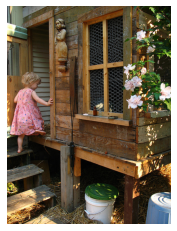

In [9]:
# seeing image to verify wether the captions predicted are correct or not


IMG_PATH = 'data/Flickr_Data/Images/'

img = cv2.imread(IMG_PATH+'1000268201_693b08cb0e.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

# Data Cleaning


In [10]:

def text_cleaning(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+", " ", sentence)
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s) > 1]
    sentence = " ".join(sentence)
    return sentence

In [11]:
text_cleaning("A cat is over the building #64 for the Master")

'cat is over the building for the master'

In [12]:
# cleaning all the captions

for key,caption_list in discriptions.items():
    for i in range (len(caption_list)):
        caption_list[i] = text_cleaning(caption_list[i]) 

In [13]:
discriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [14]:
# writing cleaning data to a text file
with open("discriptions.txt",'w') as f:
    f.write(str(discriptions))
    f.close()
    

# Vocabulary

In [15]:
discriptions = None
with open('discription_1.txt','r') as f:
    discriptions = f.read()
  
# converting str object  to dict
json_acctable_string = discriptions.replace("'","\"")
discriptions = json.loads(json_acctable_string)

In [16]:
print(type(discriptions))

<class 'dict'>


In [17]:
# Vocab

# set stors all the unique character

vocab = set()
for key in discriptions.keys():
    # this is list comprehension
    [vocab.update(sentence.split()) for sentence in discriptions[key]]

print("Total unique words in the dictionay of caption: %d" % len(vocab))


Total unique words in the dictionay of caption: 8424


In [18]:
# Total no of words accross all the sentences

total_words = []

for key in discriptions.keys():
    [total_words.append(i) for des in discriptions[key] for i in des.split()]

print("Total words %d" % len(total_words))

Total words 373837


In [19]:
print(total_words[:10])

['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs']


In [20]:
# filter words upto some threshold frequency

counter  = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))
#print(freq_cnt)

8424


In [21]:
# sorting this directory according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# filter
#print(sorted_freq_cnt)

threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]

In [22]:
# sorted all the words according to their frequency
print(len(sorted_freq_cnt))
sorted_freq_cnt[:10]


1845


[('in', 18987),
 ('the', 18420),
 ('on', 10746),
 ('is', 9345),
 ('and', 8863),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7275),
 ('of', 6723),
 ('two', 5643)]

In [23]:
total_words = [x[0] for x in sorted_freq_cnt]

In [24]:
print("Final vocab size: %d"% len(total_words))
total_words[:10]

Final vocab size: 1845


['in', 'the', 'on', 'is', 'and', 'dog', 'with', 'man', 'of', 'two']

# Prepare test/train data

In [25]:
# Loading traing and testing data
train_file_data = readfile("data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readfile("data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [26]:
print(train_file_data)

2513260012_03d33305cf.jpg
2903617548_d3e38d7f88.jpg
3338291921_fe7ae0c8f8.jpg
488416045_1c6d903fe0.jpg
2644326817_8f45080b87.jpg
218342358_1755a9cce1.jpg
2501968935_02f2cd8079.jpg
2699342860_5288e203ea.jpg
2638369467_8fc251595b.jpg
2926786902_815a99a154.jpg
2851304910_b5721199bc.jpg
3423802527_94bd2b23b0.jpg
3356369156_074750c6cc.jpg
2294598473_40637b5c04.jpg
1191338263_a4fa073154.jpg
2380765956_6313d8cae3.jpg
3197891333_b1b0fd1702.jpg
3119887967_271a097464.jpg
2276499757_b44dc6f8ce.jpg
2506892928_7e79bec613.jpg
2187222896_c206d63396.jpg
2826769554_85c90864c9.jpg
3097196395_ec06075389.jpg
3603116579_4a28a932e2.jpg
3339263085_6db9fd0981.jpg
2532262109_87429a2cae.jpg
2076906555_c20dc082db.jpg
2502007071_82a8c639cf.jpg
3113769557_9edbb8275c.jpg
3325974730_3ee192e4ff.jpg
1655781989_b15ab4cbff.jpg
1662261486_db967930de.jpg
2410562803_56ec09f41c.jpg
2469498117_b4543e1460.jpg
69710415_5c2bfb1058.jpg
3414734842_beb543f400.jpg
3006217970_90b42e6b27.jpg
2192411521_9c7e488c5e.jpg
3535879138_9281d

In [27]:
# getting image id 
train = [row.split('.')[0] for row in train_file_data.split('\n')[:-1]]
test = [row.split('.')[0] for row in test_file_data.split('\n')[:-1]]


In [28]:
print(train[:5])
#print(test[:5])

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87']


In [29]:
# train description for the image
# Tweek - add <s> and <e> token to our training data
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in discriptions[img_id]:
        cap_to_append = "<s> " + cap + " <e>"
        train_descriptions[img_id].append(cap_to_append)

In [30]:
train_descriptions['1000268201_693b08cb0e']

['<s> child in pink dress is climbing up set of stairs in an entry way <e>',
 '<s> girl going into wooden building <e>',
 '<s> little girl climbing into wooden playhouse <e>',
 '<s> little girl climbing the stairs to her playhouse <e>',
 '<s> little girl in pink dress going into wooden cabin <e>']

 # Data Preprocessing => Image 

## Transfer Learning
- Image ----->  Feature
- Text ------>  Feature

 ### Step -1 :- Image feature extraction  

In [31]:
# here we are using pre train model that is ResNet50
model = ResNet50(weights="imagenet",input_shape = (224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [32]:
# creating new model
model_new = Model(model.input,model.layers[-2].output)

In [38]:
#images = "./flicker8k-dataset/Flickr8k_Dataset/"

In [33]:
def preprocess_img(img):
    # loading image
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    # Expanding one dimension to 0th axis to make it 4d
    img = np.expand_dims(img,axis=0)
    
    # Normalizing
    img = preprocess_input(img)
    return img

In [34]:
#encoding

def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [54]:
start = time()

encoding_train = {}

for ix, img_id in enumerate(train):
    
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

Encoding image- 0
Encoding image- 100
Encoding image- 200
Encoding image- 300
Encoding image- 400
Encoding image- 500
Encoding image- 600
Encoding image- 700
Encoding image- 800
Encoding image- 900
Encoding image- 1000
Encoding image- 1100
Encoding image- 1200
Encoding image- 1300
Encoding image- 1400
Encoding image- 1500
Encoding image- 1600
Encoding image- 1700
Encoding image- 1800
Encoding image- 1900
Encoding image- 2000
Encoding image- 2100
Encoding image- 2200
Encoding image- 2300
Encoding image- 2400
Encoding image- 2500
Encoding image- 2600
Encoding image- 2700
Encoding image- 2800
Encoding image- 2900
Encoding image- 3000
Encoding image- 3100
Encoding image- 3200
Encoding image- 3300
Encoding image- 3400
Encoding image- 3500
Encoding image- 3600
Encoding image- 3700
Encoding image- 3800
Encoding image- 3900
Encoding image- 4000
Encoding image- 4100
Encoding image- 4200
Encoding image- 4300
Encoding image- 4400
Encoding image- 4500
Encoding image- 4600
Encoding image- 4700
Enco

In [55]:
# Save the bottleneck train features to disk

with open("./storage/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [60]:
start = time()

encoding_test = {}

for ix, img_id in enumerate(train):
    
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

Test Encoding image- 0
Test Encoding image- 100
Test Encoding image- 200
Test Encoding image- 300
Test Encoding image- 400
Test Encoding image- 500
Test Encoding image- 600
Test Encoding image- 700
Test Encoding image- 800
Test Encoding image- 900
Test Encoding image- 1000
Test Encoding image- 1100
Test Encoding image- 1200
Test Encoding image- 1300
Test Encoding image- 1400
Test Encoding image- 1500
Test Encoding image- 1600
Test Encoding image- 1700
Test Encoding image- 1800
Test Encoding image- 1900
Test Encoding image- 2000
Test Encoding image- 2100
Test Encoding image- 2200
Test Encoding image- 2300
Test Encoding image- 2400
Test Encoding image- 2500
Test Encoding image- 2600
Test Encoding image- 2700
Test Encoding image- 2800
Test Encoding image- 2900
Test Encoding image- 3000
Test Encoding image- 3100
Test Encoding image- 3200
Test Encoding image- 3300
Test Encoding image- 3400
Test Encoding image- 3500
Test Encoding image- 3600
Test Encoding image- 3700
Test Encoding image- 380

In [61]:
# Save the bottleneck test features to disk

with open("./storage/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [62]:
# Load the train images features from disk

with open("./storage/encoded_train_images.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

In [63]:
# Load the test images features from disk

with open("./storage/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

# Data Preprocessing => Captions

In [35]:

"""
word_to_idx is mapping between each unique word in all_vocab to int value 
and idx_to_word is vice-versa
"""
# we are assigning each unique word to some index.

ix = 1
word_to_idx = {}
idx_to_word = {}

for e in total_words:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix +=1

In [36]:
word_to_idx["dog"]
#idx_to_word[6]

6

In [37]:
#  need to add these 2 words as well

word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = '<s>'
idx_to_word[1847] = '<e>'

In [38]:

#  vocab_size is total vocabulary len +1 because we will append 0's as well. 

vocab_size = len(idx_to_word)+1
print(vocab_size)

1848


In [39]:
all_captions_len = []
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print(max_len)

35


## Data Prepration using generator function

In [40]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):

    X1, X2, y = [], [], []

    n=0

    while True:
        
        for key, desc_list in train_descriptions.items():
            n +=1

            photo = encoding_train[key+".jpg"]

            for desc in desc_list:
                
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):

                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n=0

## Word embedding

In [41]:
f = open("./GlovE/glove.6B.50d.txt", encoding='utf8')

In [42]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float")
    
    embedding_index[word] = coefs
    
f.close()

### Converting words into vectors Directly - (Embedding Layer Output)

In [43]:
def get_embedding_output():
    
    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
            
    return embedding_output

In [44]:
embedding_output = get_embedding_output()
embedding_output.shape

(1848, 50)

## Model Architecture

In [45]:
# image feature extractor model

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [46]:
# partial caption sequence model

input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [47]:
decoder1 = add([inp_img2 , inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge 2 networks
model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)

In [48]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [49]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [50]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

## Train Our Model

In [52]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [69]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len,number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./Model_weights/model_' + str(i) + '.h5')

In [58]:
model = load_model("./Model_weights/model_9.h5")

# Predictions

In [59]:
def predict_caption(photo):
    in_text = "<s>"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='<e>':
            break
        
        
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

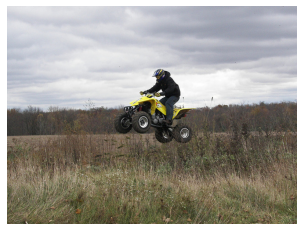

man on dirt bike is riding through the woods


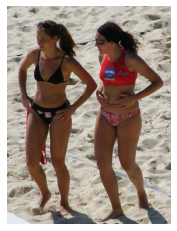

the girl in the bathing suit is running on the beach


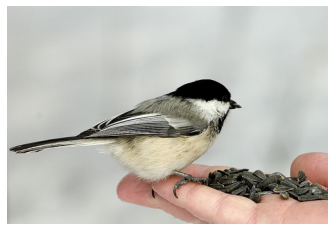

the white bird is standing on the shoulder of the water


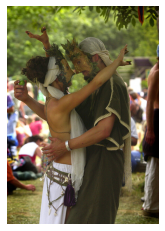

two sumo wrestlers in match


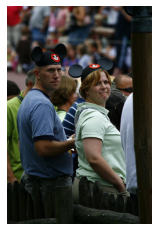

man in black shirt and black hat is standing in front of crowd


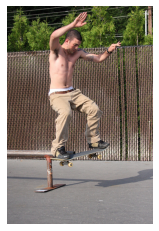

boy in red shirt and blue shorts is jumping on trampoline


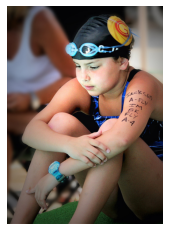

swimmer in blue shirt is wearing goggles


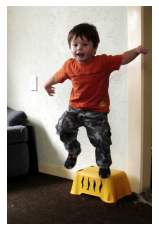

little girl in blue shirt is jumping in the air


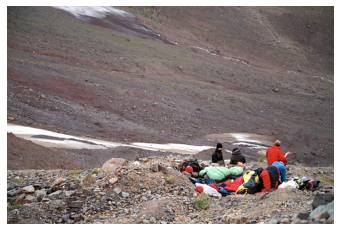

group of people are standing on top of mountain


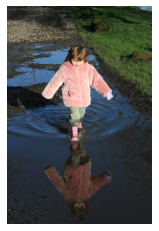

little girl in pink bathing suit is jumping off pier


In [68]:
for i in range(10):
    rn =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(IMG_PATH+"/"+img_name+".jpg")
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)